# Introduction to Spatial Data

Today we will introduce the basics of working with spatial data, including loading spatial datasets as shapefiles or CSV files, projecting data, performing geometric operations, spatially joining multiple datasets together, and simple mapping.

In [1]:
!pip install geopandas mapclassify pandas shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 979.5 kB/s eta 0:00:00


In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

## 1. Quick overview of key concepts

### What is GIS?

GIS stands for geographic information system. GIS software lets you work with spatial data, that is, data associated with locations on the Earth. These locations are represented with coordinates: longitude (x), latitude (y), and often elevation (z). With GIS software you can collect, edit, query, analyze, and visualize spatial data. Examples of GIS software include ArcGIS, QGIS, PostGIS, and GeoPandas.

### Some terminology:

- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](https://en.wikipedia.org/wiki/List_of_map_projections).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on a map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

### Common CRS parameters (and their PROJ.4 names):

- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

### Common projection types:

- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](https://en.wikipedia.org/wiki/Albers_projection) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) projection
- *equidistant* projections: [preserve distance](https://en.wikipedia.org/wiki/Map_projection#Equidistant) from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](https://en.wikipedia.org/wiki/Orthographic_projection_in_cartography) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://en.wikipedia.org/wiki/Robinson_projection) projection

## 2. Loading spatial data

You can use a GIS like ArcGIS or QGIS to open a spatial data file (typically a shapefile, GeoJSON file, or CSV file with lat-long columns). Today we'll introduce the basic concepts of spatial data and GIS operations using [geopandas](http://geopandas.org/user.html), which spatializes pandas dataframes. It uses the [shapely](https://shapely.readthedocs.io/en/latest/manual.html) package for geometry. We'll focus on common, shared concepts and operations, rather than "how-to" in the user interface of a specific GIS program.

### 2a. Loading a shapefile

Where to get census shapefiles? https://www.census.gov/cgi-bin/geo/shapefiles/index.php

The term "shapefile" is a misnomer... a shapefile is actually a folder containing multiple files that contain spatial geometry, attribute data, projection information, etc: https://en.wikipedia.org/wiki/Shapefile

In [3]:
# tell geopandas to read a shapefile with its read_file() function, passing in the shapefile folder
# this produces a GeoDataFrame
gdf = gpd.read_file(
    "https://raw.githubusercontent.com/gboeing/ppd534/main/data/tl_2017_06_tract/tl_2017_06_tract.shp"
)
gdf.shape

(8057, 13)

In [4]:
# just like regular pandas, see the first 5 rows of the GeoDataFrame
# this is a shapefile of polygon geometries, that is, tract boundaries
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,001,442700,06001442700,4427,Census Tract 4427,G5020,S,1234034,0,+37.5371514,-122.0081094,"POLYGON ((-122.01721 37.53932, -122.01719 37.5..."
1,06,001,442800,06001442800,4428,Census Tract 4428,G5020,S,1278647,0,+37.5293619,-121.9931002,"POLYGON ((-122.0023 37.52984, -122.00224 37.52..."
2,06,037,204920,06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((-118.20284 34.01966, -118.20283 34.0..."
3,06,037,205110,06037205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,-118.2142985,"POLYGON ((-118.21964 34.02628, -118.21945 34.0..."
4,06,037,205120,06037205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,+34.0187546,-118.2117956,"POLYGON ((-118.22023 34.02056, -118.22018 34.0..."


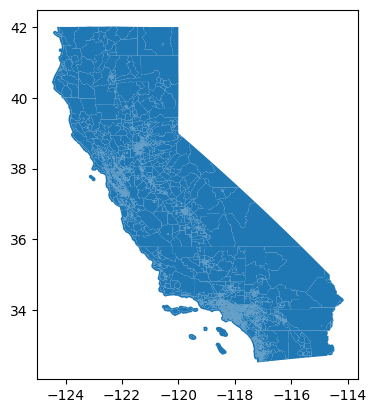

In [5]:
# mapping is as easy as calling the GeoDataFrame's plot method
ax = gdf.plot()

In [6]:
# just like in regular pandas, we can filter and subset the GeoDataFrame
# retain only tracts in LA, OC, Ventura counties
counties = ["037", "059", "111"]
gdf_tracts = gdf[gdf["COUNTYFP"].isin(counties)]
gdf_tracts.shape

(3103, 13)

In [7]:
# what is the CRS?
# this derives from the shapefile's .prj file
# always make sure the shapefile you load has prj info so you get a CRS attribute!
gdf_tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### 2b. Loading a CSV file

Often, you won't have a shapefile (which is explicitly spatial), but rather a CSV file which is implicitly spatial (contains lat-lng columns). If you're loading a CSV file (or other non-explicitly spatial file type) of lat-lng data:

  1. first load the CSV file as a DataFrame the usual way with pandas
  2. then create a new geopandas GeoDataFrame from your DataFrame
  3. manually create a geometry column
  4. set the CRS

In [8]:
# load rental listings data as a regular pandas dataframe
df = pd.read_csv("https://raw.githubusercontent.com/gboeing/ppd534/main/data/listings-la_oc_vc.csv")
df.shape

(1097, 5)

In [9]:
# examine first five rows
df.head()

,bedrooms,rent,sqft,longitude,latitude
0,NaN,2300.0,1450.0,-117.976770,33.836807
1,NaN,1075.0,NaN,-118.129403,34.141007
2,2.0,1595.0,932.0,-117.831739,33.870633
3,NaN,2720.0,1222.0,-118.338710,34.102056
4,2.0,1900.0,NaN,-118.537316,34.194225


**Always define the CRS** if you are manually creating a GeoDataFrame! Earlier, when we loaded the shapefile, geopandas loaded the CRS from the shapefile itself. But our CSV file is not explicitly spatial and it contains no CRS data, so we have to tell it what it is. In our case, the CRS is EPSG:4326, which is WGS84 lat-lng data, such as for GPS. Your data source should always tell you what CRS their coordinates are in. If they don't, ask! Don't just guess.

In [10]:
# create point geometries from the lng and lat coordinates
# notice the shapely points are represented as lng, lat so that they are equivalent to x, y
geometry = gpd.points_from_xy(x=df["longitude"], y=df["latitude"])

# create a new geopandas geodataframe manually from the pandas dataframe
# specify the geometries and the crs
gdf_listings = gpd.GeoDataFrame(df, geometry=geometry, crs="epsg:4326")
gdf_listings.shape

(1097, 6)

In [11]:
gdf_listings.head()

,bedrooms,rent,sqft,longitude,latitude,geometry
0,NaN,2300.0,1450.0,-117.976770,33.836807,POINT (-117.97677 33.83681)
1,NaN,1075.0,NaN,-118.129403,34.141007,POINT (-118.1294 34.14101)
2,2.0,1595.0,932.0,-117.831739,33.870633,POINT (-117.83174 33.87063)
3,NaN,2720.0,1222.0,-118.338710,34.102056,POINT (-118.33871 34.10206)
4,2.0,1900.0,NaN,-118.537316,34.194225,POINT (-118.53732 34.19422)


In [12]:
# what's the CRS
gdf_listings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 3. Projection, part I

Your datasets need to be in the same CRS if you want to work with them together. If they're not, then project one or both of them so they're in the same CRS.

In [13]:
gdf_tracts.crs == gdf_listings.crs

False

In [14]:
# project the tracts geodataframe to the CRS of the listings geodataframe
gdf_tracts = gdf_tracts.to_crs(gdf_listings.crs)
gdf_tracts.crs == gdf_listings.crs

True

**Be careful**: heed the difference between `gdf.crs` and `gdf.to_crs()`. The first tells you the geodataframe's current CRS. The latter projects the geodataframe to a new CRS.

## 4. Spatial predicates and operations

GIS and spatial analysis use common "computational geometry" predicates and operations like intersects, within, dissolve, and buffer.

  - *intersects* tells you if each geometry in one dataset intersects with some other (single) geometry
  - *within* tells you if each geometry in one dataset is wholly contained within some other (single) geometry
  - *dissolve* lets you aggregate data (merge their geometries together) if they share some attribute in common: this is the spatial equivalent of pandas's groupby function
  - *buffer* identifies a zone some distance around a geometry for proximity analysis
  
A spatial predicate tests the relationship between geometric objects and returns Trues or Falses (see the first two bullet points above, as well as touches, crosses, contains, overlaps, etc). A spatial operation takes geometric objects as inputs, and outputs different geometric objects (see the final two bullet points above, as well as union, intersection, difference, etc). Many predicates and operations exist in the world of GIS, but these are among the most common and useful.

### 4a. intersects

Example: I want to find all the tracts that have at least 1 rental listing within their boundaries. So, I'm going to intersect the tracts with a single geometry object that represents all the listings.

In [15]:
# create a single, unified MultiPoint object containing all the listings' geometries
# use geopandas union_all method to get a single geometry object representing all the points
unified_listings = gdf_listings["geometry"].union_all()
type(unified_listings)

shapely.geometry.multipoint.MultiPoint

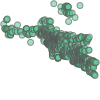

In [16]:
unified_listings

In [17]:
# get the tracts that spatially-intersect with anything in the listings dataset
mask = gdf_tracts.intersects(unified_listings)
gdf_tracts[mask].shape

(656, 13)

In [18]:
# how many tracts didn't intersect any rental listings?
gdf_tracts[~mask].shape

(2447, 13)

### 4b. dissolve

Example: I want to merge all the tracts in each county to aggregate them up to the county level. This will merge all tract-level geometries into new county-level geometries.

In [19]:
# dissolve lets you aggregate data based on shared values in some column, such as county fips codes
gdf_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2,06,037,204920,06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((-118.20284 34.01966, -118.20283 34.0..."
3,06,037,205110,06037205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,-118.2142985,"POLYGON ((-118.21964 34.02628, -118.21945 34.0..."
4,06,037,205120,06037205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,+34.0187546,-118.2117956,"POLYGON ((-118.22023 34.02056, -118.22018 34.0..."
5,06,037,206010,06037206010,2060.10,Census Tract 2060.10,G5020,S,1418138,20551,+34.0682177,-118.2320356,"POLYGON ((-118.23924 34.06726, -118.238 34.067..."
6,06,037,206020,06037206020,2060.20,Census Tract 2060.20,G5020,S,843243,30290,+34.0571230,-118.2311021,"POLYGON ((-118.23787 34.05427, -118.23784 34.0..."


In [20]:
# dissolve the tracts into counties
# aggregate their numerical columns by summing them
agg = {"ALAND": "sum", "AWATER": "sum"}
gdf_counties = gdf_tracts.dissolve("COUNTYFP", aggfunc=agg)
gdf_counties

,geometry,ALAND,AWATER
COUNTYFP,,,
037,"MULTIPOLYGON (((-118.94449 34.04664, -118.9444...",10510588451,1794793532
059,"POLYGON ((-118.11601 33.74238, -118.11565 33.7...",2048392529,406915886
111,"MULTIPOLYGON (((-119.61453 33.3148, -119.6093 ...",4773302741,946030569


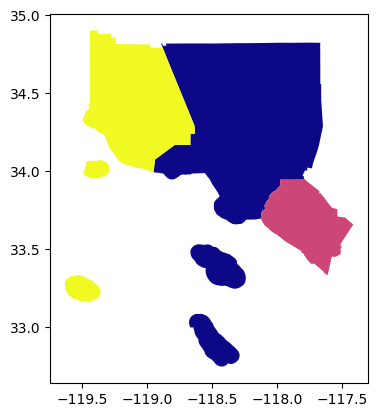

In [21]:
# quick and dirty map of our 3 counties
ax = gdf_counties.plot(cmap="plasma")

### 4c. within

Example: I want to find all the rental listings in Orange County. But my rental listings don't contain any explicit tract or county information: they only tell me lat-long. But I can use those lat-long coordinates to find which listings fall *within* the geometry (spatial boundary) of Orange County.

In [22]:
# get orange county's geometry
oc_geometry = gdf_counties.loc["059", "geometry"]
type(oc_geometry)

shapely.geometry.polygon.Polygon

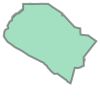

In [23]:
oc_geometry

In [24]:
# find all the listings within orange county
mask = gdf_listings.within(oc_geometry)
oc_listings = gdf_listings[mask]
oc_listings.shape

(360, 6)

## 5. Projection, part II

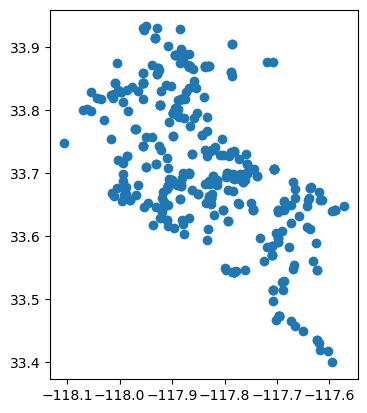

In [25]:
# map the OC rental listings
ax = oc_listings.plot()

In [26]:
oc_listings.head()

,bedrooms,rent,sqft,longitude,latitude,geometry
0,NaN,2300.0,1450.0,-117.976770,33.836807,POINT (-117.97677 33.83681)
2,2.0,1595.0,932.0,-117.831739,33.870633,POINT (-117.83174 33.87063)
6,1.0,1350.0,800.0,-117.954791,33.742979,POINT (-117.95479 33.74298)
7,2.0,1799.0,988.0,-117.883609,33.897940,POINT (-117.88361 33.89794)
10,1.0,3295.0,1825.0,-117.865620,33.774439,POINT (-117.86562 33.77444)


In [27]:
# you can easily calculate buffers
# buffer creates a polygon around your geometry with some specified distance
oc_listings_buffered = oc_listings.buffer(distance=0.1)  # what are these units? 0.1 what?
oc_listings_buffered.head()

<ipython-input-27-06f1209cd677>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  oc_listings_buffered = oc_listings.buffer(distance=0.1)  # what are these units? 0.1 what?


,0
0,"POLYGON ((-117.87677 33.83681, -117.87725 33.8..."
2,"POLYGON ((-117.73174 33.87063, -117.73222 33.8..."
6,"POLYGON ((-117.85479 33.74298, -117.85527 33.7..."
7,"POLYGON ((-117.78361 33.89794, -117.78409 33.8..."
10,"POLYGON ((-117.76562 33.77444, -117.7661 33.76..."


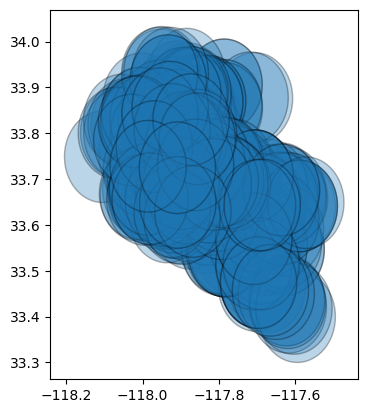

In [28]:
ax = oc_listings_buffered.plot(edgecolor="k", alpha=0.3)

But these buffers are weird because the data are not projected. They're all in lat-long degrees. Let's project it to a **projected coordinate system**.

You need to look up an appropriate projection for the spatial extents of your data/map. This is a huge topic in and of itself, so for today we'll just focus on some (over-simplified) rules of thumb:

  1. If you're mapping global data, choose a global projection like [Pseudo-Mercator](https://epsg.io/3857) or [Robinson](https://epsg.io/53030).
  2. If you're mapping national data, choose a national projection like [LCC USA](https://epsg.io/42103).
  3. If you're mapping regional data, choose a local projection, like [UTM zone 11N](https://epsg.io/32611) for Southern California.
  
![](https://github.com/gboeing/ppd430/blob/fall/modules/07-spatial-data/img/utm_zones.png?raw=1)

https://epsg.io/ is a good resource. There you can use the EPSG code or click the "proj4" link on any CRS's page to get a string you can use with geopandas.

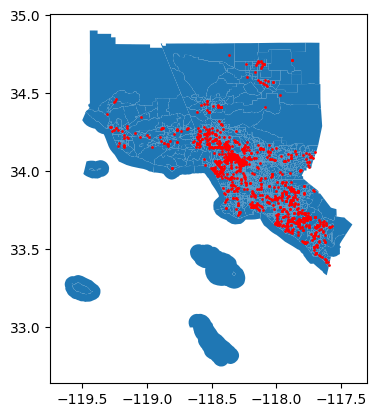

In [29]:
# plot the tracts, then the listings on top of them
ax = gdf_tracts.plot()
ax = gdf_listings.plot(ax=ax, c="r", markersize=1)

In [30]:
# define a CRS appropriate for projecting CA data
ca_crs = "epsg:26945"
gdf_tracts = gdf_tracts.to_crs(ca_crs)
gdf_listings = gdf_listings.to_crs(ca_crs)

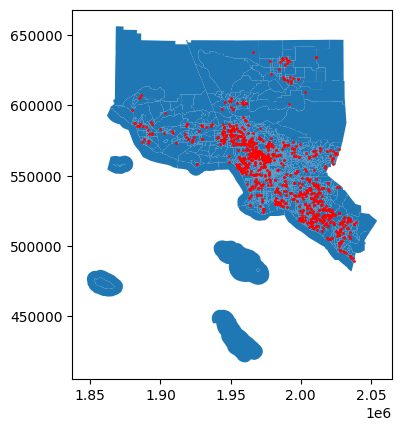

In [31]:
# plot the projected tracts + listings
ax = gdf_tracts.plot()
ax = gdf_listings.plot(ax=ax, c="r", markersize=1)

In [32]:
# specify a projection manually with a proj4 string
# we'll map with UTM zone 11 which is good for Southern California (see link above)
utm_11 = "+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
gdf_tracts = gdf_tracts.to_crs(utm_11)
gdf_listings = gdf_listings.to_crs(utm_11)

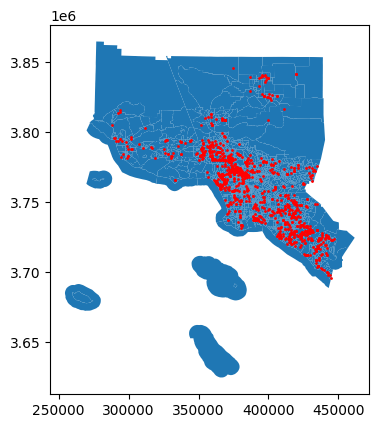

In [33]:
ax = gdf_tracts.plot()
ax = gdf_listings.plot(ax=ax, c="r", markersize=1)

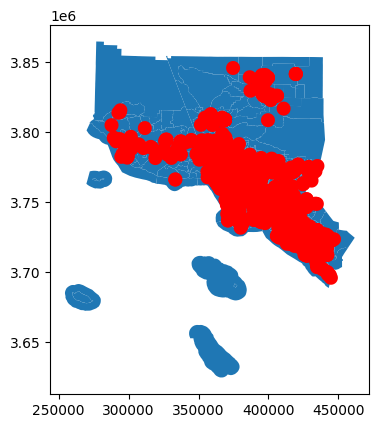

In [34]:
# buffer listings by 5km then plot again
ax = gdf_tracts.plot()
ax = gdf_listings.buffer(5000).plot(ax=ax, fc="r")

So that's our projected data and shapefile. Notice how the shape has changed, and how the units make more sense: they are in meters now. So our buffers are a 5km radius from each point. Buffers are useful for tasks like, for example, finding all the transit stations within 1km of a census tract.

## 6. Non-spatial merge vs spatial joins

### 6a. Quick review of pandas (non-spatial) merge

Joins two dataframes based on some column they have in common.

In [35]:
# load the CA tract-level census data from previous weeks
tract_indicators = pd.read_csv(
    "https://raw.githubusercontent.com/gboeing/ppd534/main/data/census_tracts_data_ca.csv",
    dtype={"GEOID10": str},
)
tract_indicators.shape

(8057, 28)

In [36]:
# 5 rows of the tracts census data
tract_indicators.head()

,GEOID10,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_asian,pct_male,pct_single_family_home,med_home_value,...,pct_commute_drive_alone,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,county_name
0,06001437701,3745.0,29.4,59.6,11.7,9.9,303.0,49.7,19.2,310700.0,...,64.3,11.9,15.7,93.8,11.5,35.5,38.6,6,1,Alameda
1,06001437102,4586.0,36.6,34.2,10.1,8.5,1813.0,45.8,28.0,384400.0,...,78.1,10.4,45.5,91.2,22.0,32.9,48.8,6,1,Alameda
2,06001437101,7186.0,40.2,20.6,13.9,5.9,3623.0,49.4,76.1,582400.0,...,75.6,3.1,34.5,90.0,40.0,46.1,42.3,6,1,Alameda
3,06001450752,5854.0,38.4,8.0,22.7,4.3,3514.0,51.2,80.5,1008600.0,...,60.1,1.4,15.9,94.5,65.7,44.2,44.5,6,1,Alameda
4,06001450751,8963.0,36.7,4.8,22.4,1.2,6020.0,48.7,77.4,922500.0,...,59.3,2.7,10.9,78.8,78.4,35.8,50.1,6,1,Alameda


In [37]:
# 5 rows of the tracts shapefile
gdf_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2,06,037,204920,06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,+34.0175004,-118.1974975,"POLYGON ((388943.127 3764987.77, 388943.969 37..."
3,06,037,205110,06037205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,+34.0245059,-118.2142985,"POLYGON ((387400.85 3765741.082, 387420.402 37..."
4,06,037,205120,06037205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,+34.0187546,-118.2117956,"POLYGON ((387338.632 3765107.344, 387343.26 37..."
5,06,037,206010,06037206010,2060.10,Census Tract 2060.10,G5020,S,1418138,20551,+34.0682177,-118.2320356,"POLYGON ((385646.166 3770306.143, 385761.152 3..."
6,06,037,206020,06037206020,2060.20,Census Tract 2060.20,G5020,S,843243,30290,+34.0571230,-118.2311021,"POLYGON ((385755.167 3768864.61, 385757.936 37..."


In [38]:
# merge the 2 datasets on a shared column: tract fips code
gdf_tracts_ind = pd.merge(
    left=gdf_tracts, right=tract_indicators, how="left", left_on="GEOID", right_on="GEOID10"
)
gdf_tracts_ind.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pct_commute_drive_alone,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,county_name
0,06,037,204920,06037204920,2049.20,Census Tract 2049.20,G5020,S,909972,0,...,86.4,28.3,19.0,91.7,8.7,14.0,39.9,6,37,Los Angeles
1,06,037,205110,06037205110,2051.10,Census Tract 2051.10,G5020,S,286962,0,...,57.4,29.4,20.9,90.8,5.9,6.5,53.1,6,37,Los Angeles
2,06,037,205120,06037205120,2051.20,Census Tract 2051.20,G5020,S,1466129,0,...,72.3,35.5,23.2,91.2,4.8,10.4,47.9,6,37,Los Angeles
3,06,037,206010,06037206010,2060.10,Census Tract 2060.10,G5020,S,1418138,20551,...,49.6,38.7,21.4,94.0,13.6,22.3,49.4,6,37,Los Angeles
4,06,037,206020,06037206020,2060.20,Census Tract 2060.20,G5020,S,843243,30290,...,54.0,15.2,52.9,41.2,7.3,60.8,11.1,6,37,Los Angeles


In [39]:
# merging a dataframe (right) into a (left) geodataframe, we got a geodataframe back and kept our CRS
gdf_tracts_ind.crs

<Projected CRS: +proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 6b. Geopandas spatial join

Joins two geodataframes based on some shared spatial location. Let's say I want to know which county each rental listing is in: I need to *join* the listings to the county that each listing is within, using the gdf_counties GeoDataFrame we created earlier by dissolving the tracts.

In [40]:
# remember (again): always double-check CRS before any spatial operations
gdf_listings.crs == gdf_counties.crs

False

In [41]:
# they don't match, so project the counties to the CRS of the listings
gdf_counties = gdf_counties.to_crs(gdf_listings.crs)
gdf_listings.crs == gdf_counties.crs

True

In [42]:
# spatial join listings to counties
# this is a left-join to ensure we retain all the listings in our resulting merged dataset
gdf_listings_counties = gpd.sjoin(gdf_listings, gdf_counties, how="left", predicate="within")
gdf_listings_counties.shape

(1097, 9)

In [43]:
# what did it do? inspect first 5 rows of listings
gdf_listings_counties.head()

,bedrooms,rent,sqft,longitude,latitude,geometry,COUNTYFP,ALAND,AWATER
0,NaN,2300.0,1450.0,-117.976770,33.836807,POINT (409623.602 3744490.687),059,2048392529,406915886
1,NaN,1075.0,NaN,-118.129403,34.141007,POINT (395872.216 3778366.755),037,10510588451,1794793532
2,2.0,1595.0,932.0,-117.831739,33.870633,POINT (423073.433 3748123.368),059,2048392529,406915886
3,NaN,2720.0,1222.0,-118.338710,34.102056,POINT (376516.869 3774280.739),037,10510588451,1794793532
4,2.0,1900.0,NaN,-118.537316,34.194225,POINT (358349.816 3784759.737),037,10510588451,1794793532


In [44]:
groups = gdf_listings_counties.groupby("COUNTYFP")

In [45]:
# which counties have the highest median asking rents?
groups["rent"].median().sort_values(ascending=False)

,rent
COUNTYFP,
059,1777.5
037,1698.5
111,1697.0


In [46]:
# which counties have the most bedrooms per unit in the listings?
groups["bedrooms"].mean().sort_values(ascending=False)

,bedrooms
COUNTYFP,
037,1.993197
059,1.953846
111,1.914894


In [47]:
# which counties have the most listings?
groups["geometry"].count().sort_values(ascending=False)

,geometry
COUNTYFP,
037,685
059,360
111,52


In [48]:
# create a subset of only those listings in orange county
# equivalent to gdf_listings.within(oc_geometry) from earlier
oc_listings = gdf_listings_counties[gdf_listings_counties["COUNTYFP"] == "059"]
oc_listings.shape

(360, 9)

## 7. Mapping

In [49]:
# get the merged tracts + indicators that are in OC
oc_tracts_ind = gdf_tracts_ind[gdf_tracts_ind["COUNTYFP"] == "059"]
oc_tracts_ind.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pct_commute_drive_alone,pct_below_poverty,pct_college_grad_student,pct_same_residence_year_ago,pct_bachelors_degree,pct_english_only,pct_foreign_born,state,county,county_name
168,06,059,990100,06059990100,9901,Census Tract 9901,G5020,S,0,352603583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,59,Orange
169,06,059,062649,06059062649,626.49,Census Tract 626.49,G5020,S,3369929,8846,...,79.6,13.5,62.5,84.0,53.0,74.0,28.5,6,59,Orange
170,06,059,032058,06059032058,320.58,Census Tract 320.58,G5020,S,5975932,0,...,76.3,1.2,11.7,82.5,68.4,76.5,14.5,6,59,Orange
171,06,059,032061,06059032061,320.61,Census Tract 320.61,G5020,S,9605979,0,...,78.3,2.6,23.6,88.9,62.4,92.4,12.7,6,59,Orange
566,06,059,021813,06059021813,218.13,Census Tract 218.13,G5020,S,4073720,622433,...,90.2,0.0,NaN,15.7,5.7,64.3,0.0,6,59,Orange


In [50]:
# drop the tract that has 0 land area... it's just in the ocean
# census bureau uses these to represent territory boundary without making on-land tracts extend out into ocean
oc_tracts_ind = oc_tracts_ind[oc_tracts_ind["ALAND"] > 0]

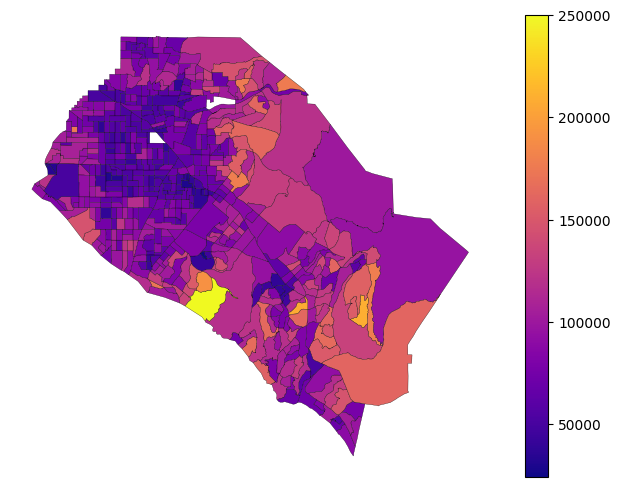

In [51]:
# map using GeoDataFrame plot method with some style configurations
ax = oc_tracts_ind.plot(
    column="med_household_income", cmap="plasma", edgecolor="k", lw=0.2, figsize=(9, 6), legend=True
)

# turn the "axis" off and save to disk
ax.axis("off")
ax.get_figure().savefig("oc-income.png", dpi=300, bbox_inches="tight")

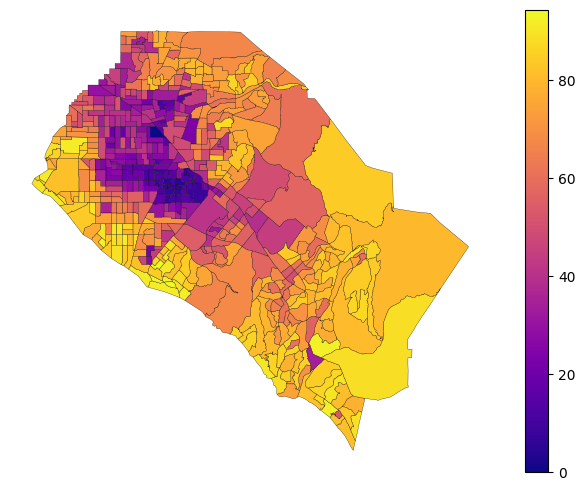

In [52]:
# map a different column
ax = oc_tracts_ind.plot(
    column="pct_english_only", cmap="plasma", edgecolor="k", lw=0.2, figsize=(9, 6), legend=True
)
ax.axis("off")
ax.get_figure().savefig("oc-language.png", dpi=300, bbox_inches="tight")

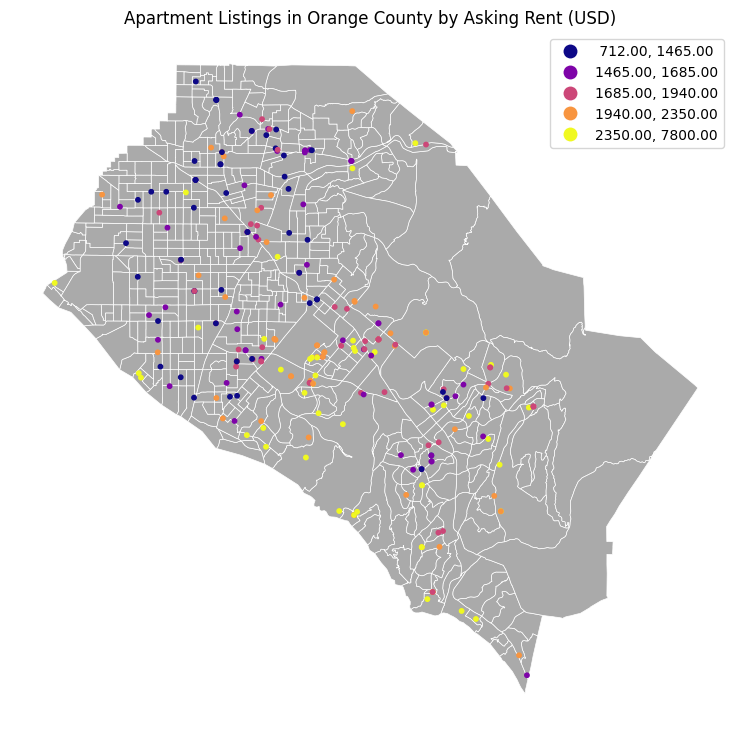

In [53]:
# map tracts as a basemap with listings as points on top
ax = oc_tracts_ind.plot(facecolor="#aaaaaa", edgecolor="w", lw=0.5, figsize=(12, 9), legend=False)

# now plot listings, colored by asking rent
ax = oc_listings.dropna().plot(
    ax=ax, markersize=10, legend=True, cmap="plasma", column="rent", scheme="Quantiles"
)
ax.axis("off")
ax.set_title("Apartment Listings in Orange County by Asking Rent (USD)")
ax.get_figure().savefig("oc-listings.png", dpi=300, bbox_inches="tight")

In [54]:
# now it's your turn
# make the plot above more effective and accessible using the visualization best practices you have read about